## SC2008 Lab4: Analysing Network Data Log

In [2]:
!pip3 install ipwhois

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx
# from ipwhois import IPWhois

In [4]:
# Given SFlow Format in Table 1
format = ['Type', 'sflow_agent_address', 'inputPort', 'outputPort',
               'src_MAC', 'dst_MAC', 'ethernet_type', 'in_vlan', 'out_vlan',
               'src_IP', 'dst_IP', 'IP_protocol', 'ip_tos', 'ip_ttl',
               'src_transport_port', 'dst_transport_port', 'tcp_flags',
               'packet_size', 'IP_size', 'sampling_rate', 'unknown']
# path of data: /users/ananyakapoor/Desktop/Lab4_data.csv

In [5]:
data = pd.read_csv('/users/ananyakapoor/Desktop/Lab4_data.csv', header = None, names = format)
data.drop('unknown', axis=1, inplace = True) # Drop column with null/unknown values
data.head(5)

,Type,sflow_agent_address,inputPort,outputPort,src_MAC,dst_MAC,ethernet_type,in_vlan,out_vlan,src_IP,dst_IP,IP_protocol,ip_tos,ip_ttl,src_transport_port,dst_transport_port,tcp_flags,packet_size,IP_size,sampling_rate
0,FLOW,203.30.38.251,137,200,d404ff55fd4d,80711fc76001,0x0800,919,280,130.246.176.22,140.115.32.81,6,0x00,50,51216,23505,0x10,1518,1500,2048
1,FLOW,203.30.38.251,129,193,609c9f851b00,0031466b23cf,0x0800,11,919,155.69.160.32,64.233.188.128,6,0x00,56,23159,80,0x10,74,52,2048
2,FLOW,203.30.38.251,137,200,d404ff55fd4d,80711fc76001,0x0800,919,280,130.246.176.53,140.115.32.83,6,0x00,50,50041,20739,0x10,1518,1500,2048
3,FLOW,203.30.38.251,129,135,609c9f851b00,002688cd5fc7,0x0800,11,919,155.69.160.32,54.169.174.79,17,0x00,120,54241,26510,0x10,116,94,2048
4,FLOW,203.30.38.251,130,199,00239cd087c1,544b8cf9a7df,0x0800,919,600,137.132.228.15,193.62.192.8,6,0x00,56,53923,34262,0x10,70,52,2048


In [6]:
data.tail(5)

,Type,sflow_agent_address,inputPort,outputPort,src_MAC,dst_MAC,ethernet_type,in_vlan,out_vlan,src_IP,dst_IP,IP_protocol,ip_tos,ip_ttl,src_transport_port,dst_transport_port,tcp_flags,packet_size,IP_size,sampling_rate
69365,FLOW,203.30.38.251,258,199,204e71cf1b0f,ccef48570144,0x0800,537,601,207.241.228.157,210.48.222.9,6,0x00,56,443,57434,0x10,1522,1500,2048
69366,FLOW,203.30.38.251,131,193,00a742233e9e,0031466b23cf,0x0800,43,919,192.122.131.36,216.58.203.234,6,0x00,121,4920,443,0x10,1442,1420,2048
69367,FLOW,203.30.38.251,130,199,00239cd087c1,544b8cf9a7df,0x0800,919,600,137.132.228.15,193.62.192.8,6,0x00,56,34153,3123,0x10,82,64,2048
69368,FLOW,203.30.38.251,129,193,609c9f851b00,0031466b23cf,0x0800,11,919,155.69.196.9,74.125.56.6,17,0x00,58,56221,60786,0x10,1267,1245,2048
69369,FLOW,203.30.38.251,137,200,d404ff55fd4d,80711fc76001,0x0800,919,280,14.139.196.58,192.101.107.153,6,0x00,57,34625,41211,0x10,58,40,2048


### EXERCISE 4A: TOP TALKERS AND LISTENERS

In [7]:
# Top 5 IP addresses by number of packets sent
top_talkers = data['src_IP'].value_counts().nlargest(5).to_frame()

top_talkers = top_talkers.reset_index().rename(columns = {'index':'IP Address', 
                                                        'src_IP':'No. of Packets'})
top_talkers

## use the whois command on terminal to determine the organisations for each

,IP Address,No. of Packets
0,193.62.192.8,3041
1,155.69.160.32,2975
2,130.14.250.11,2604
3,14.139.196.58,2452
4,140.112.8.139,2056


In [8]:
# Top 5 unique IP addresses by number of packets received
top_listeners = data['dst_IP'].value_counts().nlargest(5).to_frame()

top_listeners = top_listeners.reset_index().rename(columns = {'index':'IP Address', 
                                                        'dst_IP':'No. of Packets'})
top_listeners

## use the whois command on terminal to determine the organisations for each

,IP Address,No. of Packets
0,103.37.198.100,3841
1,137.132.228.15,3715
2,202.21.159.244,2446
3,192.101.107.153,2368
4,103.21.126.2,2056


### EXERCISE 4B: TRANSPORT PROTOCOL

In [9]:
packet_df = data['IP_protocol'].value_counts().to_frame()
packet_df = packet_df.reset_index().rename(columns={'index':'Header Value',
                                                    'IP_protocol':'No. of Packets'})

percent_total = []
for i in range(len(packet_df)):
    percent_total.append(packet_df['No. of Packets'][i] * 100 / len(data))

packet_df['Total Percentage'] = percent_total
packet_df

# Manual Table1-: TCP==6, UDP==17
tcp_packet_df = packet_df.loc[packet_df['Header Value'] == 6]
udp_packet_df = packet_df.loc[packet_df['Header Value'] == 17]

data_frames = [tcp_packet_df, udp_packet_df]
final_df = pd.concat(data_frames)
final_df

,Header Value,No. of Packets,Total Percentage
0,6,56064,80.818798
1,17,9462,13.639902


### EXERCISE 4C: APPLICATIONS PROTOCOL

In [10]:
destination_df = data['dst_transport_port'].value_counts().nlargest(5).to_frame()

destination_df = destination_df.reset_index().rename(columns = {'index':'Destination Port', 
                                                        'dst_transport_port':'No. of Packets'})
destination_df

,Destination Port,No. of Packets
0,443,13423
1,80,2647
2,52866,2068
3,45512,1356
4,56152,1341


To determine the service of each port refer to: https://www.adminsub.net/tcp-udp-port-finder/

Based on the data, we get:

1. Port 443- HTTPS
2. Port 80 - HTTP
3. Port 52866 - Dynamic and/or private ports
4. Port 45512 - Unassigned
5. Port 56152 - Dynamic and/or private ports


In [11]:
# appending the above data to the destination_df

ports = {45512: 'Unassigned', 
                443: 'HTTPS',
                80: 'HTTP',
                52866: 'Dynamic/Private Ports',
                56152: 'Dynamic/Private Ports',
                0: 'Reserved Port'}
Service_Provided = [] #empty 

for i in destination_df['Destination Port']:
    try:
        Service_Provided.append([ports[i]])
    except:
            Service_Provided.append('Unknown')
destination_df['Service_Provided']= Service_Provided
destination_df

,Destination Port,No. of Packets,Service_Provided
0,443,13423,[HTTPS]
1,80,2647,[HTTP]
2,52866,2068,[Dynamic/Private Ports]
3,45512,1356,[Unassigned]
4,56152,1341,[Dynamic/Private Ports]


### EXERCISE 4D: TRAFFIC

In [12]:
# use the IP packet size to calculate the estimated total traffic over the monitored period of 15 seconds

total_packet_size = sum(data['IP_size'])
print('Total packet size:', sum(data['IP_size']))

total_traffic = total_packet_size/(8 * pow(2, 20))
print('Total traffic in Mb: ', total_traffic, 'Mb')

print(f"Total traffic in Mb(rounded to 3 decimal digits): {total_traffic: .3f} Mb")

Total packet size: 64777822
Total traffic in Mb:  7.722118139266968 Mb
Total traffic in Mb(rounded to 3 decimal digits):  7.722 Mb


### EXERCISE 4E: ADDITIONAL ANALYSIS


### Top 5 Communication Pairs

In [13]:
import seaborn as sns

In [30]:
# Top 5 Communication Pairs
comm_pairs_df= data.groupby(['src_IP', 'dst_IP']).size().sort_values(ascending=False).to_frame()

comm_pairs_df.columns = ['No. of Packets']
comm_pairs_df = comm_pairs_df.reset_index()

top_comm_df = comm_pairs_df[:5]
top_comm_df

,src_IP,dst_IP,No. of Packets
0,193.62.192.8,137.132.228.15,3041
1,130.14.250.11,103.37.198.100,2599
2,14.139.196.58,192.101.107.153,2368
3,140.112.8.139,103.21.126.2,2056
4,137.132.228.15,193.62.192.8,1910


### Protocol Distribution

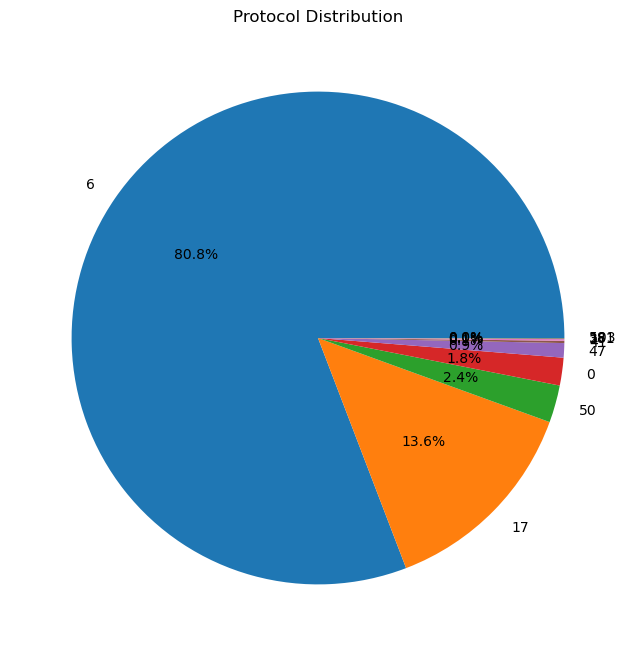

In [16]:
# Calculate protocol distribution
protocol_distribution = data['IP_protocol'].value_counts()

# Plot protocol distribution as a pie chart
plt.figure(figsize=(8, 8))
protocol_distribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Protocol Distribution')
plt.ylabel('')
plt.show()

### Network Graph for Top 20 Source-Destination Pairs (sorted by traffic volume)

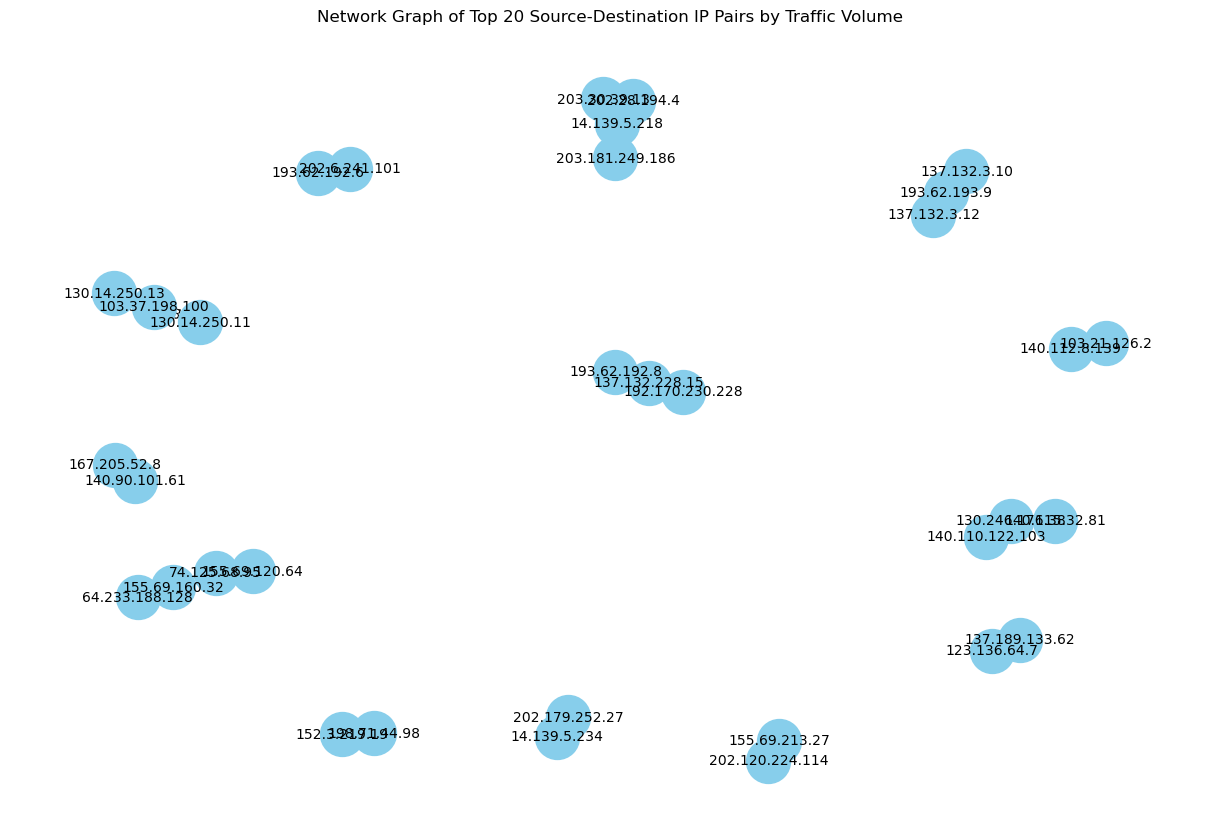

In [24]:
traffic = data.groupby(['src_IP', 'dst_IP'])['IP_size'].sum().reset_index()

# Get top 10 sources and destinations based on volume
top_src = traffic.groupby('src_IP')['IP_size'].sum().nlargest(20).index
top_dst = traffic.groupby('dst_IP')['IP_size'].sum().nlargest(20).index

# Filter for traffic involving top source and destination IPs
filtered_traffic = traffic[(traffic['src_IP'].isin(top_src)) & (traffic['dst_IP'].isin(top_dst))]

# Create a graph from the filtered traffic
G = nx.from_pandas_edgelist(filtered_traffic, 'src_IP', 'dst_IP', ['IP_size'])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_color='black')
edge_labels = nx.get_edge_attributes(G, 'IP_size')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Network Graph of Top 20 Source-Destination IP Pairs by Traffic Volume')
plt.show()